In [1]:
try:
    import google.colab  # noqa: F401

    # specify the version of DataEval (==X.XX.X) for versions other than the latest
    %pip install -q dataeval[all] maite-datasets
except Exception:
    pass

In [2]:
import polars as pl
from maite_datasets.image_classification import CIFAR10

from dataeval.core import calculate
from dataeval.core.flags import ImageStats
from dataeval.data import Metadata, Select
from dataeval.data.selections import Limit, Shuffle
from dataeval.evaluators.bias import Balance, Diversity, Parity

pl.Config.set_tbl_rows(-1);

In [3]:
# Load in the CIFAR10 dataset and limit to 20,000 images with random shuffling
cifar10 = Select(CIFAR10("data", image_set="base", download=True), [Limit(20000), Shuffle(seed=0)])
print(cifar10)

Select Dataset
--------------
    Selections: [Limit(size=20000), Shuffle(seed=0)]
    Selected Size: 20000

CIFAR10 Dataset
---------------
    Transforms: []
    Image Set: base
    Metadata: {'id': 'CIFAR10_base', 'index2label': {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}, 'split': 'base'}
    Path: /builds/jatic/aria/dataeval/docs/source/notebooks/data/cifar10
    Size: 60000


In [4]:
metadata = Metadata(cifar10)
print(f"Factor names: {metadata.factor_names}")

Processing datum metadata:   0%|          | 0/20000 [00:00<?, ?it/s]

Factor names: ['id', 'batch_num']


In [5]:
# Balance at index 0 is always class
Balance().evaluate(metadata).balance[2]

factor_name,mi_value
cat,f64
"""batch_num""",0.0


In [6]:
# Calculate pixel and visual statistics
calc_results = calculate(cifar10, stats=ImageStats.PIXEL | ImageStats.VISUAL)

# Append the factors to the metadata
metadata.add_factors(calc_results["stats"])

Processing images for PixelStat, VisualStat:   0%|          | 0/20000 [00:00<?, ?it/s]

In [7]:
# Exclude the id and batch_num as it is not a relevant factor for bias analysis
metadata.exclude = ["id", "batch_num"]

# Provide binning for the continuous statistical factors using 5 uniform-width bins for each factor
keys = ("mean", "std", "var", "skew", "kurtosis", "entropy", "brightness", "darkness", "sharpness", "contrast", "zeros")
metadata.continuous_factor_bins = dict.fromkeys(keys, 5)

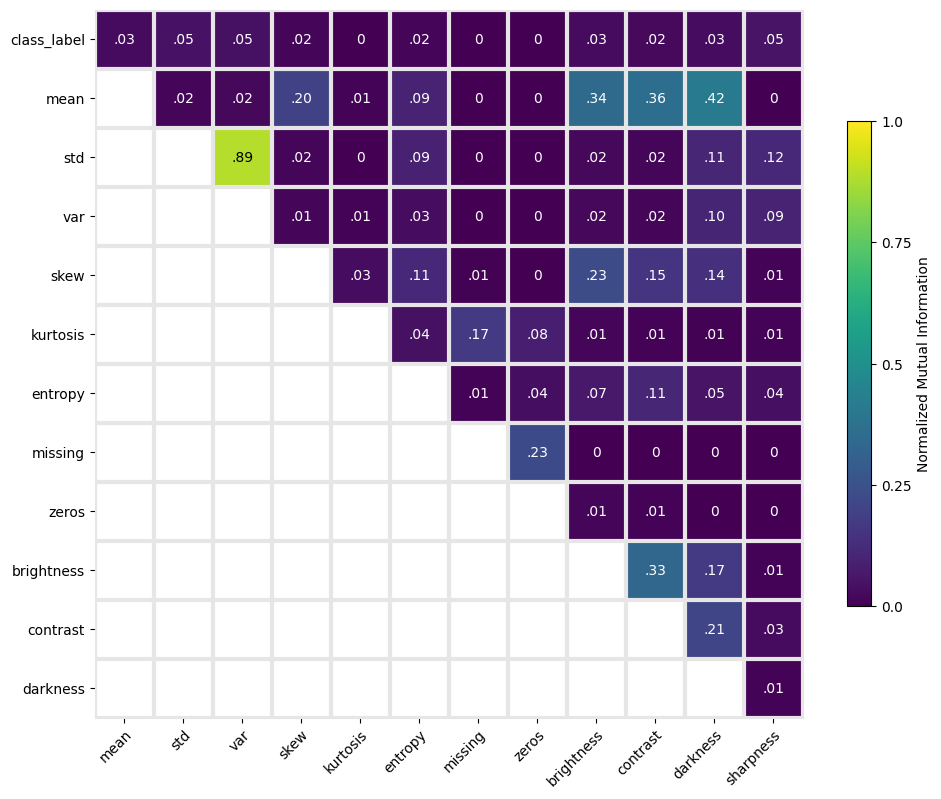

In [8]:
balance_output = Balance().evaluate(metadata)
_ = balance_output.plot()

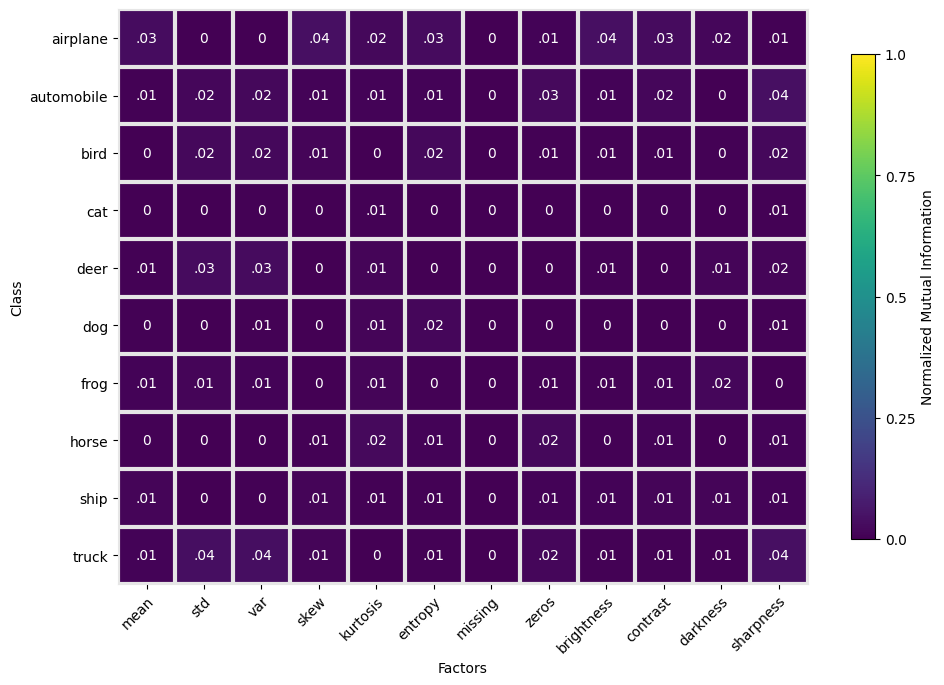

In [9]:
_ = balance_output.plot(plot_classwise=True)

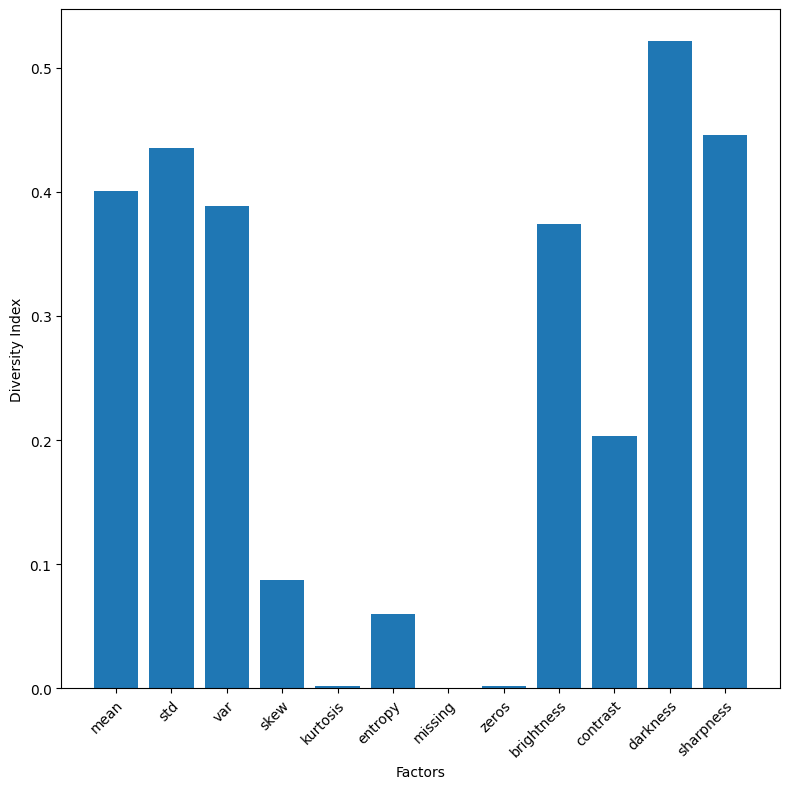

In [10]:
diversity_output = Diversity().evaluate(metadata)
_ = diversity_output.plot()

In [11]:
parity_output = Parity().evaluate(metadata)
parity_output.factors

factor_name,score,p_value,is_correlated,has_insufficient_data
cat,f64,f64,bool,bool
"""mean""",0.157132,0.0,false,false
"""std""",0.203624,0.0,false,true
"""var""",0.196541,0.0,false,true
"""skew""",0.124439,2.3339e-244,false,true
"""kurtosis""",0.034223,1.6581e-12,false,true
"""entropy""",0.111562,3.8866e-193,false,true
"""missing""",0.0,1.0,false,false
"""zeros""",0.01428,0.038631,false,true
"""brightness""",0.161594,0.0,false,true
